# REDES NEURAIS CONVOLUCIONAIS - EXEMPLO 1 (Orlando) - Dígitos escritos a mão:

In [1]:
import tensorflow as tf
import keras
import matplotlib
import numpy as np
import pandas as pd
import random
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Flatten, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import utils as np_utils
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold

In [ ]:
# para RGB (255, 255, 255) ---> cor BRANCA
# para RGB (0, 0, 0) ---> cor PRETA

In [2]:
# Divisão dos dados de Teste e Treinamento:
(X_treinamento, y_treinamento), (X_teste, y_teste) = mnist.load_data()
print(f'O treinamento possui um total de dados + dimensão de {X_treinamento.shape} e o conjunto de teste possui {X_teste.shape}, totalizando {28*28} pixels')

O treinamento possui um total de dados + dimensão de (60000, 28, 28) e o conjunto de teste possui (10000, 28, 28), totalizando 784 pixels


Text(0.5, 1.0, 'Classe 1')

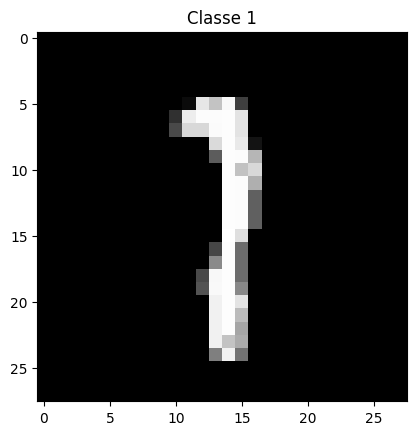

In [3]:
# função para mostrar os diversos números na base de treinamento:
numero = random.randint(0, 60000)
plt.imshow(X_treinamento[numero], cmap='gray')
plt.title('Classe ' + str(y_treinamento[numero]))

In [4]:
# Adicionar 1 ao final é a informação referente ao canal, já que vamos estar trabalhando na escla de cinza, se caso RGB, seria 3.
X_treinamento = X_treinamento.reshape(X_treinamento.shape[0], 28, 28, 1)
X_teste = X_teste.reshape(X_teste.shape[0], 28, 28, 1)
# Conversão para valores de Float:
X_treinamento = X_treinamento.astype('float32')
X_teste = X_teste.astype('float32')
# Para estar dentro do intervalo
X_treinamento /= 255
X_teste /= 255
X_treinamento.max(), X_treinamento.min()

(1.0, 0.0)

In [5]:
# aqui, será feita uma codificação para melhor representar os números:
# Número 1 será: [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]
# Número 5 será: [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]
# Número 9 será: [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]
y_treinamento = np_utils.to_categorical(y_treinamento, 10)
y_teste = np_utils.to_categorical(y_teste, 10)

In [6]:
# Representar que será feita em uma sequencia de camadas:
rede_neural = Sequential()
# Camada de entrada, especificando x, y e canal:
rede_neural.add(InputLayer(shape =(28, 28, 1)))
# ( 1 ) Operador de Convolução ---> Cria o Mapa de Características
rede_neural.add(Conv2D(filters = 32,           # filters (quantidade de Kernels ou Detectores de Características,
                       kernel_size = (3, 3),   # valores padrão de 32, em ordem de 2);
                       activation = 'relu'))   # kernel_size (tamanho da matriz de multiplicidade); activation (função de ativação) 
# ( 1.1 ) Normalização/Camada de processamento ---> Normalizar a saída da camada anterior
rede_neural.add(BatchNormalization()) # Reduzir o desvio interno de covariância e overfitting; Acelerar o treinamento e aumentar a estabilidade da rede.
# ( 2 ) Pooling ---> Seleciona o maior valor do Mapa de Características (seleção dos pixels principais)
rede_neural.add(MaxPooling2D(pool_size = (2, 2)))
# ( 2.1 ) Camada de Convolução Secundária ---> 
rede_neural.add(Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu'))
rede_neural.add(BatchNormalization())
rede_neural.add(MaxPooling2D(pool_size = (2, 2)))
# ( 3 ) Flattening ---> Transforma o formato agrupado (pooled) de matricial para vetorial
rede_neural.add(Flatten())
# ( 4 ) Rede Neural Densa ---> Utiliza o formato vetorial como entrada da Rede Neural Densa
rede_neural.add(Dense(units = 128, activation = 'relu'))
rede_neural.add(Dropout(0.2)) # desativa aleatoriamente 20% dos 128 neurônios, isso força a rede a não depender demais de neurônios específicos, evitando que ela decore os dados de treino.
rede_neural.add(Dense(units = 128, activation = 'relu'))
rede_neural.add(Dropout(0.2))
rede_neural.add(Dense(units = 10, activation = 'softmax')) # Transformar a saída bruta da rede (chamada de logits) em probabilidades normalizadas; 
# Se voltar [0.01, 0.02, 0.10, 0.02, 0.80, 0.01, 0.02, 0.01, 0.005, 0.015] significa que a rede está 90% confiante de que o número na imagem é o dígito 4.

In [7]:
rede_neural.summary()

# 1 - a primeira convolução reduz de 26*26 para 13*13
# 2 - a primeira pooling não consegue reduzir as dimensões
# 3 - a segunda convolução reduz de 13*13 para 11*11
# 4 - a segunda pooling consegue reduzir de 11*11 para 5*5
# 5 - no flattening, após vetorizar a matriz, temos 5*5*32 = 800


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 11, 11, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       102,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 130,154 (508.41 KB)

 Trainable params: 130,026 (507.91 KB)

 Non-trainable params: 128 (512.00 B)

In [8]:
# Prepara o modelo para o treinamento, definindo os componentes essenciais:
rede_neural.compile(loss='categorical_crossentropy',  # Função de perda usada para problemas de classificação multiclasse. Ela mede a diferença entre a distribuição prevista e a real (one-hot encoded).
                    optimizer='adam',                 # Otimizador que combina as vantagens do AdaGrad e RMSProp. Ajusta a taxa de aprendizado automaticamente durante o treinamento, o que acelera a convergência e melhora o desempenho em redes profundas.
                    metrics=['accuracy'])             # Desempenho do modelo, calcula a proporção de previsões corretas.


# Executa o treinamento propriamente dito: Alimenta o modelo com os dados (X, y); Executa o processo de forward e backward propagation; Calcula a perda e as métricas a cada época; Atualiza os pesos da rede com base no gradiente descendente; Pode usar validação para acompanhar o desempenho em dados não vistos
historico = rede_neural.fit(X_treinamento, # É enviado a rede os dados de entrada (features), sendo pixels
                            y_treinamento, # É enviado a rede os dados de saída (rótulos), sendo classes ([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
                            batch_size = 128, # Define o número de amostras que serão processadas antes de atualizar os pesos da rede. Batch menor = atualização mais frequente (mais barulho). Batch maior = atualização mais estável. 128 é um valor comum que equilibra desempenho e estabilidade.
                            epochs = 5, # Número de vezes que o modelo irá percorrer tudo. Mais épocas geralmente resultam em melhor aprendizado, mas também em risco de overfitting.
                            validation_data = (X_teste, y_teste)) # Dados separados para validação durante o treinamento. Permite monitorar o desempenho do modelo em dados que ele **nunca viu**,

Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.8579 - loss: 0.4577 - val_accuracy: 0.9553 - val_loss: 0.1535
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.9803 - loss: 0.0666 - val_accuracy: 0.9868 - val_loss: 0.0368
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.9877 - loss: 0.0431 - val_accuracy: 0.9864 - val_loss: 0.0429
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.9883 - loss: 0.0400 - val_accuracy: 0.9892 - val_loss: 0.0345
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9911 - loss: 0.0295 - val_accuracy: 0.9886 - val_loss: 0.0363


In [9]:
resultado = rede_neural.evaluate(X_teste, y_teste)

print(f"Perda (loss): {resultado[0]:.4f}")
print(f"Acurácia (accuracy): {resultado[1]*100:.2f}%")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9855 - loss: 0.0441
Perda (loss): 0.0363
Acurácia (accuracy): 98.86%


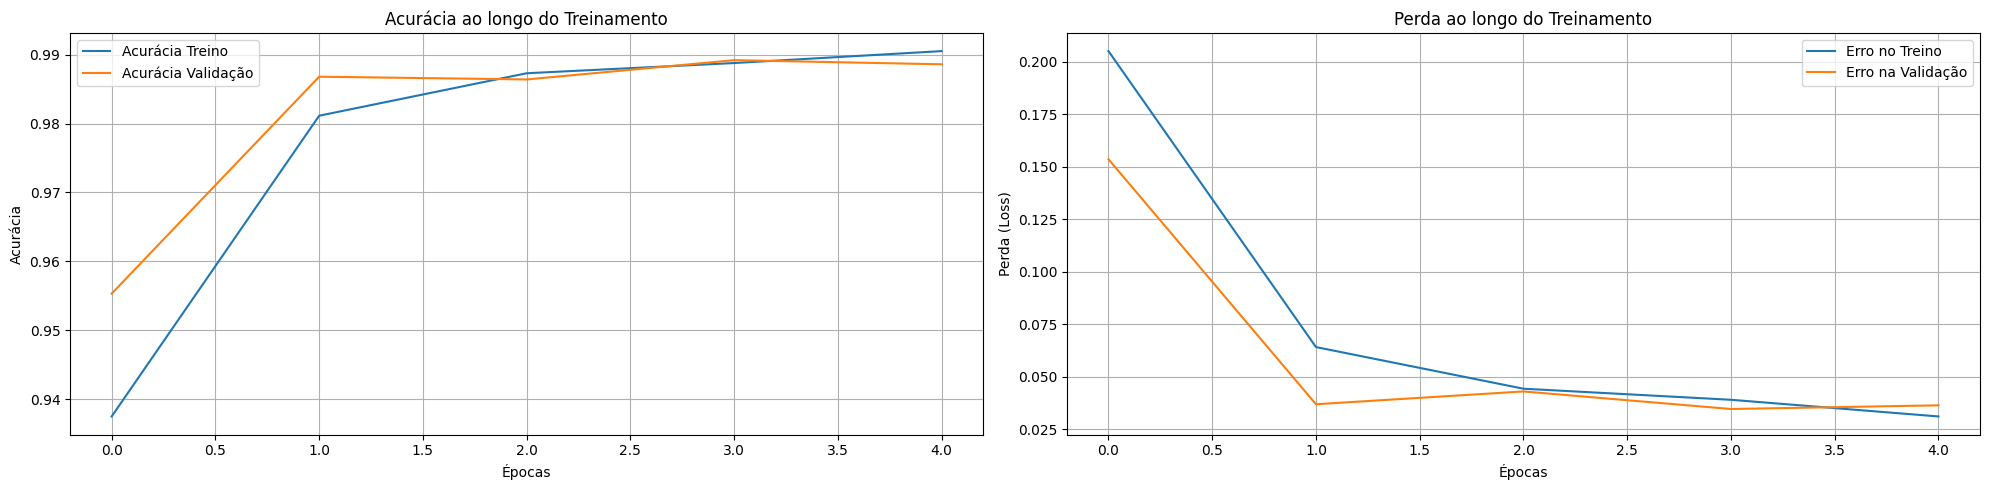

In [11]:
# Criar figura com 2 subplots lado a lado
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# --- Gráfico da Acurácia ---
axs[0].plot(historico.history['accuracy'], label='Acurácia Treino')
axs[0].plot(historico.history['val_accuracy'], label='Acurácia Validação')
axs[0].set_title('Acurácia ao longo do Treinamento')
axs[0].set_xlabel('Épocas')
axs[0].set_ylabel('Acurácia')
axs[0].legend()
axs[0].grid(True)

# --- Gráfico da Perda ---
axs[1].plot(historico.history['loss'], label='Erro no Treino')
axs[1].plot(historico.history['val_loss'], label='Erro na Validação')
axs[1].set_title('Perda ao longo do Treinamento')
axs[1].set_xlabel('Épocas')
axs[1].set_ylabel('Perda (Loss)')
axs[1].legend()
axs[1].grid(True)

# Ajustar o layout para não sobrepor
plt.tight_layout()
plt.show()

In [12]:
# Previsões
y_pred = rede_neural.predict(X_teste)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_teste, axis=1)

# Obter relatório como dicionário
relatorio_dict = classification_report(y_true, y_pred_classes, output_dict=True)

# Converter em DataFrame
relatorio_df = pd.DataFrame(relatorio_dict).T

# Converter métricas para porcentagem (exceto support)
for coluna in ['precision', 'recall', 'f1-score']:
    relatorio_df[coluna] = relatorio_df[coluna] * 100

# Arredondar para 5 casas decimais
relatorio_df = relatorio_df.round(5)

# Reordenar e renomear colunas para exibir com mais clareza
relatorio_df = relatorio_df[['precision', 'recall', 'f1-score', 'support']]
relatorio_df.columns = ['Precisão (%)', 'Revocação (%)', 'F1-Score (%)', 'Suporte']

# Exibir tabela com espaçamento e alinhamento
espaco = 12
print("\n" + "Relatório de Classificação (em porcentagem):".center(70))
print("-" * 70)
print(f"{'Classe':<{espaco}}{'Precisão (%)':>{espaco}}{'Recall (%)':>{espaco}}{'F1-Score (%)':>{espaco}}{'Suporte':>{espaco}}")
print("-" * 70)
for idx, row in relatorio_df.iterrows():
    print(f"{idx:<{espaco}}{row['Precisão (%)']:>{espaco}.5f}{row['Revocação (%)']:>{espaco}.5f}{row['F1-Score (%)']:>{espaco}.5f}{row['Suporte']:>{espaco}.0f}")
print("-" * 70)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

             Relatório de Classificação (em porcentagem):             
----------------------------------------------------------------------
Classe      Precisão (%)  Recall (%)F1-Score (%)     Suporte
----------------------------------------------------------------------
0               99.48770    99.08163    99.28425         980
1               99.29825    99.73568    99.51648        1135
2               99.03007    98.93411    98.98206        1032
3               98.13908    99.20792    98.67061        1010
4               99.48560    98.47251    98.97646         982
5               97.04595    99.43946    98.22813         892
6               99.57627    98.12109    98.84332         958
7               98.92892    98.83268    98.88078        1028
8               99.37952    98.66530    99.02112         974
9               98.11508    98.01784    98.06644        1009
accuracy        98.86000    98.86000    98.86000           1
macro avg    

### Precision ---> Entre todas as vezes que o modelo previu uma classe, quantas vezes ele acertou? (Qualidade das previsões positivas)

### Recall --->  Entre todas as vezes que a classe realmente apareceu, quantas vezes o modelo detectou? (Capacidade de identificar os verdadeiros positivos)

### F1-Score ---> Média harmônica entre precision e recall (Equilíbrio entre qualidade da predição e cobertura da classe)

### Suporte ---> Número de amostras reais de cada classe (Tamanho de cada classe no conjunto de teste)

# Testador de probabilidades individual

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


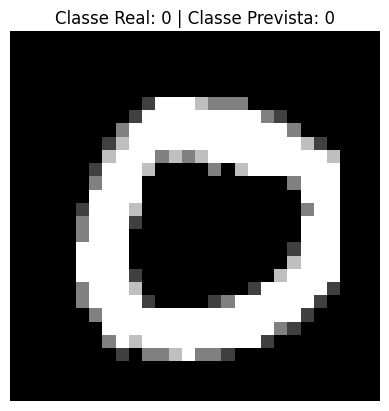


Tabela de Probabilidades Previstas (Softmax):
 Classe  Probabilidade (%)
      0          100.00000
      6            0.00000
      5            0.00000
      7            0.00000
      9            0.00000
      8            0.00000
      1            0.00000
      4            0.00000
      2            0.00000
      3            0.00000


In [13]:
import matplotlib.pyplot as plt
import random
indice_imagem = random.randint(0, 60000)  # ou qualquer índice entre 0 e len(X_teste) - 1
testar_uma_imagem = True  # Mude para False se não quiser testar manualmente

if testar_uma_imagem:
    indice_imagem = random.randint(0, X_teste.shape[0] - 1) # Seleciona um índice aleatório da base de teste
    imagem = X_teste[indice_imagem]
    imagem_exp = np.expand_dims(imagem, axis=0)
    pred = rede_neural.predict(imagem_exp) # Fazer previsão
    classe_prevista = np.argmax(pred)
    classe_real = np.argmax(y_teste[indice_imagem])
    plt.imshow(imagem.reshape(28, 28), cmap='gray')
    plt.title(f'Classe Real: {classe_real} | Classe Prevista: {classe_prevista}')
    plt.axis('off')
    plt.show()
    probs = pred[0] # Criar DataFrame com as probabilidades
    tabela_prob = pd.DataFrame({"Classe": list(range(len(probs))), "Probabilidade (%)": [p * 100 for p in probs]})
    tabela_prob = tabela_prob.sort_values(by="Probabilidade (%)", ascending=False) # Ordenar da maior para a menor probabilidade
    pd.options.display.float_format = '{:.5f}'.format # Ajustar visualização
    print("\nTabela de Probabilidades Previstas (Softmax):")
    print(tabela_prob.to_string(index=False))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


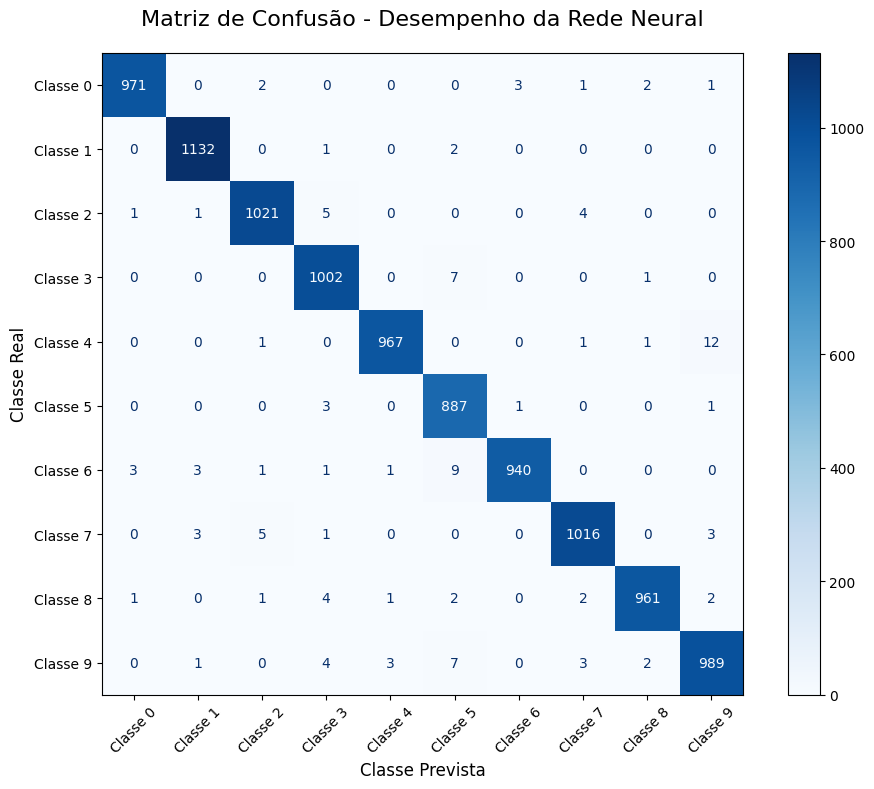

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Obter previsões da rede
y_pred_prob = rede_neural.predict(X_teste)
y_pred = np.argmax(y_pred_prob, axis=1)  # Classes previstas
y_true = np.argmax(y_teste, axis=1)      # Classes reais

# Matriz de confusão
cm = confusion_matrix(y_true, y_pred)

# Criar display com rótulos melhorados
labels = [f"Classe {i}" for i in range(10)]  # Exemplo: Classe 0, Classe 1, ...

# Criar e personalizar o gráfico
fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(ax=ax, cmap='Blues', values_format='d')

# Melhorando as legendas e títulos
ax.set_title("Matriz de Confusão - Desempenho da Rede Neural", fontsize=16, pad=20)
ax.set_xlabel("Classe Prevista", fontsize=12)
ax.set_ylabel("Classe Real", fontsize=12)
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


C:\Users\CLIENTE\AppData\Local\Temp\ipykernel_14676\128343519.py:39: UserWarning: Glyph 128721 (\N{OCTAGONAL SIGN}) missing from current font.
  plt.tight_layout()
C:\Users\CLIENTE\AppData\Local\Temp\ipykernel_14676\128343519.py:40: UserWarning: Glyph 128721 (\N{OCTAGONAL SIGN}) missing from current font.
  plt.savefig("C:/Users/CLIENTE/Downloads/erros_classificacao_grid.png", dpi=300, bbox_inches='tight')
c:\Users\CLIENTE\anaconda3\envs\orlando\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128721 (\N{OCTAGONAL SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


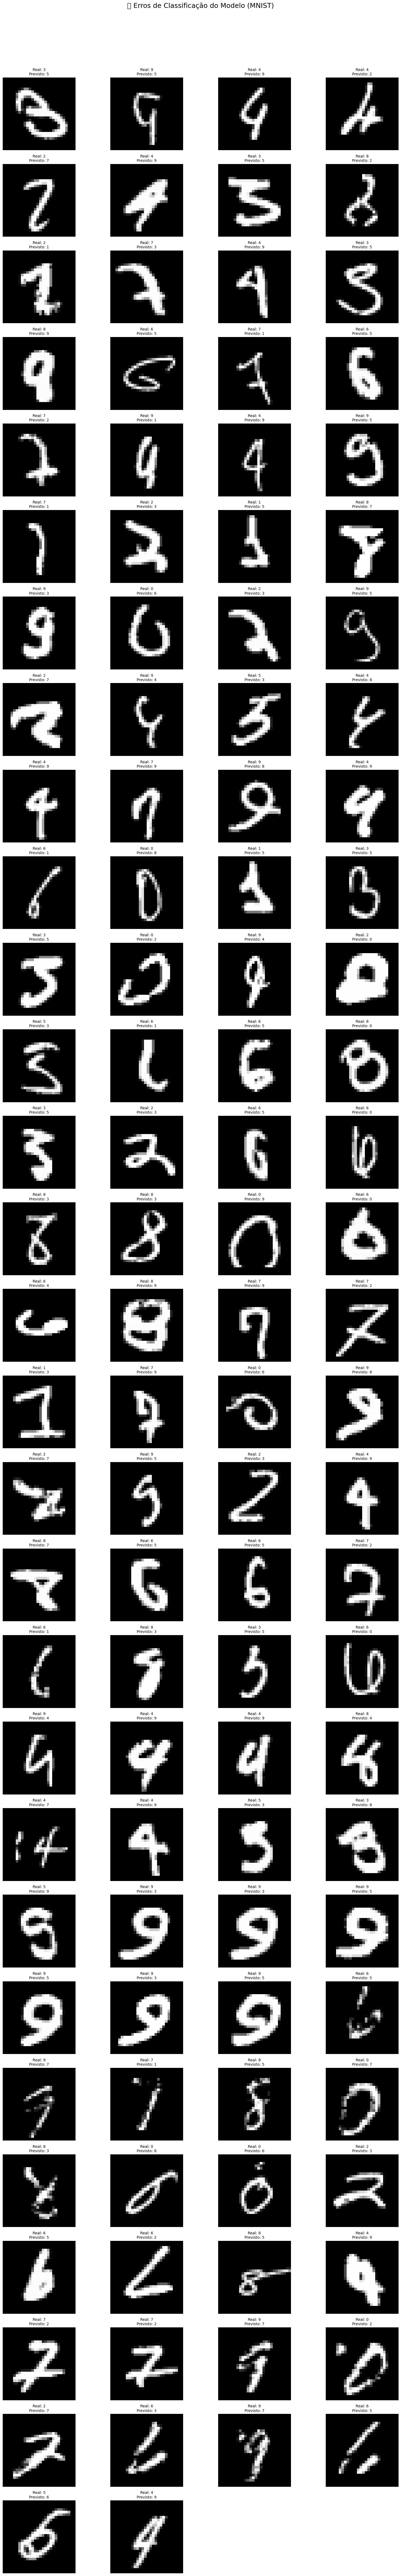

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Obter previsões do classificador
y_pred_prob = rede_neural.predict(X_teste)
y_pred = np.argmax(y_pred_prob, axis=1)           # Classes previstas
y_true = np.argmax(y_teste, axis=1)               # Corrige o formato de one-hot para inteiro

# Mapeamento direto de índices (0-9) para rótulos (nomes numéricos)
indice_para_nome = {i: str(i) for i in range(10)}

# Preparar listas para armazenar erros
imagens_com_erro = []
rotulos_reais = []
rotulos_previstos = []

# Identificar erros diretamente com base no array X_teste
for idx in range(len(y_true)):
    if y_true[idx] != y_pred[idx]:
        imagens_com_erro.append(X_teste[idx])
        rotulos_reais.append(y_true[idx])
        rotulos_previstos.append(y_pred[idx])

# ---------- PLOTAGEM DOS ERROS EM GRADE ---------- #
num_erros = len(imagens_com_erro)
cols = 4
rows = int(np.ceil(num_erros / cols))

plt.figure(figsize=(16, rows * 3.2))
for i in range(num_erros):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(imagens_com_erro[i].reshape(28, 28), cmap='gray')
    real = indice_para_nome[rotulos_reais[i]]
    pred = indice_para_nome[rotulos_previstos[i]]
    plt.title(f"Real: {real}\nPrevisto: {pred}", fontsize=10)
    plt.axis('off')

plt.suptitle("Erros de Classificação do Modelo (MNIST)", fontsize=18, y=1.02)
plt.tight_layout()
plt.savefig("C:/Users/CLIENTE/Downloads/erros_classificacao_grid_digitos.png", dpi=300, bbox_inches='tight')
plt.show()


# Validação Cruzada

In [ ]:
seed = 5; np.random.seed(seed)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
resultados = []
for indice_treinamento, indice_teste in kfold.split(X_treinamento, np.zeros(shape=(y_treinamento.shape[0],1))):
    print(f"\nÍndices de Treinamento: {indice_treinamento} e Índice de Teste: {indice_teste}\n")
    # Representar que será feita em uma sequencia de camadas:
    rede_neural = Sequential()
    # Camada de entrada, especificando x, y e canal:
    rede_neural.add(InputLayer(shape =(28, 28, 1)))
    # ( 1 ) Operador de Convolução ---> Cria o Mapa de Características
    rede_neural.add(Conv2D(filters = 32,           # filters (quantidade de Kernels ou Detectores de Características,
                        kernel_size = (3, 3),   # valores padrão de 32, em ordem de 2);
                        activation = 'relu'))   # kernel_size (tamanho da matriz de multiplicidade); activation (função de ativação) 
    # ( 1.1 ) Normalização/Camada de processamento ---> Normalizar a saída da camada anterior
    rede_neural.add(BatchNormalization()) # Reduzir o desvio interno de covariância e overfitting; Acelerar o treinamento e aumentar a estabilidade da rede.
    # ( 2 ) Pooling ---> Seleciona o maior valor do Mapa de Características (seleção dos pixels principais)
    rede_neural.add(MaxPooling2D(pool_size = (2, 2)))
    # ( 2.1 ) Camada de Convolução Secundária ---> 
    rede_neural.add(Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu'))
    rede_neural.add(BatchNormalization())
    rede_neural.add(MaxPooling2D(pool_size = (2, 2)))
    # ( 3 ) Flattening ---> Transforma o formato agrupado (pooled) de matricial para vetorial
    rede_neural.add(Flatten())
    # ( 4 ) Rede Neural Densa ---> Utiliza o formato vetorial como entrada da Rede Neural Densa
    rede_neural.add(Dense(units = 128, activation = 'relu'))
    rede_neural.add(Dropout(0.2)) # desativa aleatoriamente 20% dos 128 neurônios, isso força a rede a não depender demais de neurônios específicos, evitando que ela decore os dados de treino.
    rede_neural.add(Dense(units = 128, activation = 'relu'))
    rede_neural.add(Dropout(0.2))
    rede_neural.add(Dense(units = 10, activation = 'softmax')) # Transformar a saída bruta da rede (chamada de logits) em probabilidades normalizadas; 
    # Se voltar [0.01, 0.02, 0.10, 0.02, 0.80, 0.01, 0.02, 0.01, 0.005, 0.015] significa que a rede está 90% confiante de que o número na imagem é o dígito 4.
    # Prepara o modelo para o treinamento, definindo os componentes essenciais:
    rede_neural.compile(loss='categorical_crossentropy',  # Função de perda usada para problemas de classificação multiclasse. Ela mede a diferença entre a distribuição prevista e a real (one-hot encoded).
                        optimizer='adam',                 # Otimizador que combina as vantagens do AdaGrad e RMSProp. Ajusta a taxa de aprendizado automaticamente durante o treinamento, o que acelera a convergência e melhora o desempenho em redes profundas.
                        metrics=['accuracy'])             # Desempenho do modelo, calcula a proporção de previsões corretas.
    # Executa o treinamento propriamente dito: Alimenta o modelo com os dados (X, y); Executa o processo de forward e backward propagation; Calcula a perda e as métricas a cada época; Atualiza os pesos da rede com base no gradiente descendente; Pode usar validação para acompanhar o desempenho em dados não vistos
    historico = rede_neural.fit(X_treinamento, # É enviado a rede os dados de entrada (features), sendo pixels
                                y_treinamento, # É enviado a rede os dados de saída (rótulos), sendo classes ([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
                                batch_size = 128, # Define o número de amostras que serão processadas antes de atualizar os pesos da rede. Batch menor = atualização mais frequente (mais barulho). Batch maior = atualização mais estável. 128 é um valor comum que equilibra desempenho e estabilidade.
                                epochs = 5, # Número de vezes que o modelo irá percorrer tudo. Mais épocas geralmente resultam em melhor aprendizado, mas também em risco de overfitting.
                                validation_data = (X_teste, y_teste)) # Dados separados para validação durante o treinamento. Permite monitorar o desempenho do modelo em dados que ele **nunca viu**,
    resultado = rede_neural.evaluate(X_treinamento[indice_teste], y_treinamento[indice_teste])
    print(f"\nPerda (loss): {resultado[0]:.4f}")
    print(f"Acurácia (accuracy): {resultado[1]*100:.2f}%")
    # Criar figura com 2 subplots lado a lado
    fig, axs = plt.subplots(1, 2, figsize=(20, 5))

    # --- Gráfico da Acurácia ---
    axs[0].plot(historico.history['accuracy'], label='Acurácia Treino')
    axs[0].plot(historico.history['val_accuracy'], label='Acurácia Validação')
    axs[0].set_title('Acurácia ao longo do Treinamento')
    axs[0].set_xlabel('Épocas')
    axs[0].set_ylabel('Acurácia')
    axs[0].legend()
    axs[0].grid(True)

    # --- Gráfico da Perda ---
    axs[1].plot(historico.history['loss'], label='Erro no Treino')
    axs[1].plot(historico.history['val_loss'], label='Erro na Validação')
    axs[1].set_title('Perda ao longo do Treinamento')
    axs[1].set_xlabel('Épocas')
    axs[1].set_ylabel('Perda (Loss)')
    axs[1].legend()
    axs[1].grid(True)

    # Ajustar o layout para não sobrepor
    plt.tight_layout()
    plt.show()
    # Previsões
    y_pred = rede_neural.predict(X_treinamento[indice_teste])
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_treinamento[indice_teste], axis=1)

    # Obter relatório como dicionário
    relatorio_dict = classification_report(y_true, y_pred_classes, output_dict=True)

    # Converter em DataFrame
    relatorio_df = pd.DataFrame(relatorio_dict).T

    # Converter métricas para porcentagem (exceto support)
    for coluna in ['precision', 'recall', 'f1-score']:
        relatorio_df[coluna] = relatorio_df[coluna] * 100

    # Arredondar para 5 casas decimais
    relatorio_df = relatorio_df.round(5)

    # Reordenar e renomear colunas para exibir com mais clareza
    relatorio_df = relatorio_df[['precision', 'recall', 'f1-score', 'support']]
    relatorio_df.columns = ['Precisão (%)', 'Revocação (%)', 'F1-Score (%)', 'Suporte']

    # Exibir tabela com espaçamento e alinhamento
    espaco = 12
    print("\n" + "Relatório de Classificação (em porcentagem):".center(70))
    print("-" * 70)
    print(f"{'Classe':<{espaco}}{'Precisão (%)':>{espaco}}{'Recall (%)':>{espaco}}{'F1-Score (%)':>{espaco}}{'Suporte':>{espaco}}")
    print("-" * 70)
    for idx, row in relatorio_df.iterrows():
        print(f"{idx:<{espaco}}{row['Precisão (%)']:>{espaco}.5f}{row['Revocação (%)']:>{espaco}.5f}{row['F1-Score (%)']:>{espaco}.5f}{row['Suporte']:>{espaco}.0f}")
    print("-" * 70)
    resultados.append(resultado[1])
print(f"\nSegue o resultado da validação cruzada: \n{resultados}")